# Fresh and Rotten Fruit Classification

For Bangkit final project purpose

## Import Dependencies

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [2]:
## Set GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16910043463938155669
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4828102656
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17706601435560543357
physical_device_desc: "device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Dataset preparation

Using TensorFlow backend.
(376, 336)


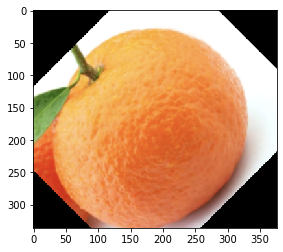

In [4]:
import random
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

filenames = os.listdir('dataset/train/freshoranges')
sample = random.choice(filenames)
image = load_img('dataset/train/freshoranges/'+sample)
plt.imshow(image)
print(image.size)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255,
                                    rotation_range=15,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.1,
                                    horizontal_flip=True,fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
                    'dataset/train',
                    target_size = (150,150),
                    batch_size = 10,
                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
                    'dataset/test',
                    target_size=(150,150),
                    batch_size= 10,
                    class_mode='categorical'
)

Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


In [ ]:
ImageDataGenerator?

In [6]:
## Define a Callback function
desired_accuracy = 0.999


class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>desired_accuracy):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

my_callback = myCallback()

## Model Architecture

In [7]:
baseModel = ResNet50V2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(150, 150, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(6, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs = headModel)

# Freeze the baseModel layers
for layer in baseModel.layers :
    layer.trainable = False

In [10]:
model.summary()

________________
conv4_block2_preact_relu (Activ (None, 10, 10, 1024) 0           conv4_block2_preact_bn[0][0]     
__________________________________________________________________________________________________
conv4_block2_1_conv (Conv2D)    (None, 10, 10, 256)  262144      conv4_block2_preact_relu[0][0]   
__________________________________________________________________________________________________
conv4_block2_1_bn (BatchNormali (None, 10, 10, 256)  1024        conv4_block2_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block2_1_relu (Activation (None, 10, 10, 256)  0           conv4_block2_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block2_2_pad (ZeroPadding (None, 12, 12, 256)  0           conv4_block2_1_relu[0][0]        
____________________________________________________________________________________________

In [9]:
## Hyperparameter
INIT_LR = 1e-3
BS = 10
EPOCHS = 25

In [11]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [ ]:
model.fit?

In [12]:
history = model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=10,
            callbacks=[my_callback]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1091 steps, validate for 270 steps
Epoch 1/10
1091/1091 [==============================] - 245s 225ms/step - loss: 0.1689 - accuracy: 0.9343 - val_loss: 0.2075 - val_accuracy: 0.9448
Epoch 2/10
1091/1091 [==============================] - 230s 210ms/step - loss: 0.1235 - accuracy: 0.9520 - val_loss: 0.2225 - val_accuracy: 0.9419
Epoch 3/10
1091/1091 [==============================] - 226s 207ms/step - loss: 0.1121 - accuracy: 0.9573 - val_loss: 0.2351 - val_accuracy: 0.9427
Epoch 4/10
1091/1091 [==============================] - 224s 206ms/step - loss: 0.1030 - accuracy: 0.9604 - val_loss: 0.1940 - val_accuracy: 0.9523
Epoch 5/10
1091/1091 [==============================] - 218s 200ms/step - loss: 0.0973 - accuracy: 0.9629 - val_loss: 0.1909 - val_accuracy: 0.9533
Epoch 6/10
1091/1091 [==============================] - 194s 178ms/step - loss: 0.0936 - accuracy: 0.9647 - val_loss: 0.1971 - val_accuracy: 0.9510
Epoch 7/10
1091/1

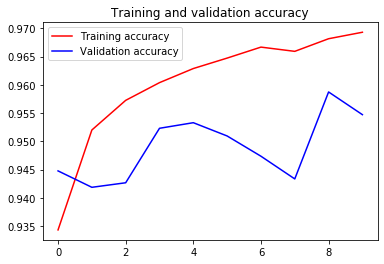

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [14]:
model.save('transfer_learningv1.h5')